In [1]:
import rootutils
import os
import torch 

# Setup root directory
root = rootutils.setup_root(
                    search_from=os.getcwd(),
                    indicator=[".project-root",'.git'],
                    project_root_env_var=True,             # set the PROJECT_ROOT environment variable to root directory
                    dotenv=True,                           # load environment variables from .env if exists in root directory
                    pythonpath=True,                       # add root directory to the PYTHONPATH (helps with imports)
                    cwd=True                               # change current working directory to the root directory (helps with filepaths)
        )
print(root)

/home/muthu/Downloads/Project


In [2]:
# from src.backend.torch_local.models.msports_todo import InternViT
from src.backend.torch_local.models.msports import LitSportModel
from src.backend.torch_local.datamodules.sports_dm import LitSportsDataModule
from src.backend.torch_local.utils.helpers import distribution_fn,show_batch_images,custom_check_image,custom_loader
from src.backend.torch_local.utils.logging_utils import plot_confusion_matrix

In [3]:
sports_data_dir  = r"/home/muthu/Downloads/Project/data/processed/sports"

In [4]:
os.listdir(sports_data_dir)

['sports.csv', 'valid', 'test', 'train', '.gitkeep']

In [5]:
dm = LitSportsDataModule(32,12,False,sports_data_dir)

calling Sports  🤾‍♂️ DataModule


In [6]:
dm.prepare_data()

In [7]:
dm.setup('fit')
dm.setup('test')

In [8]:
batch = next(iter(dm.train_dataloader()))
images, labels = batch
images.shape, labels.shape, images.device

(torch.Size([32, 3, 224, 224]), torch.Size([32]), device(type='cpu'))

<Figure size 640x480 with 0 Axes>

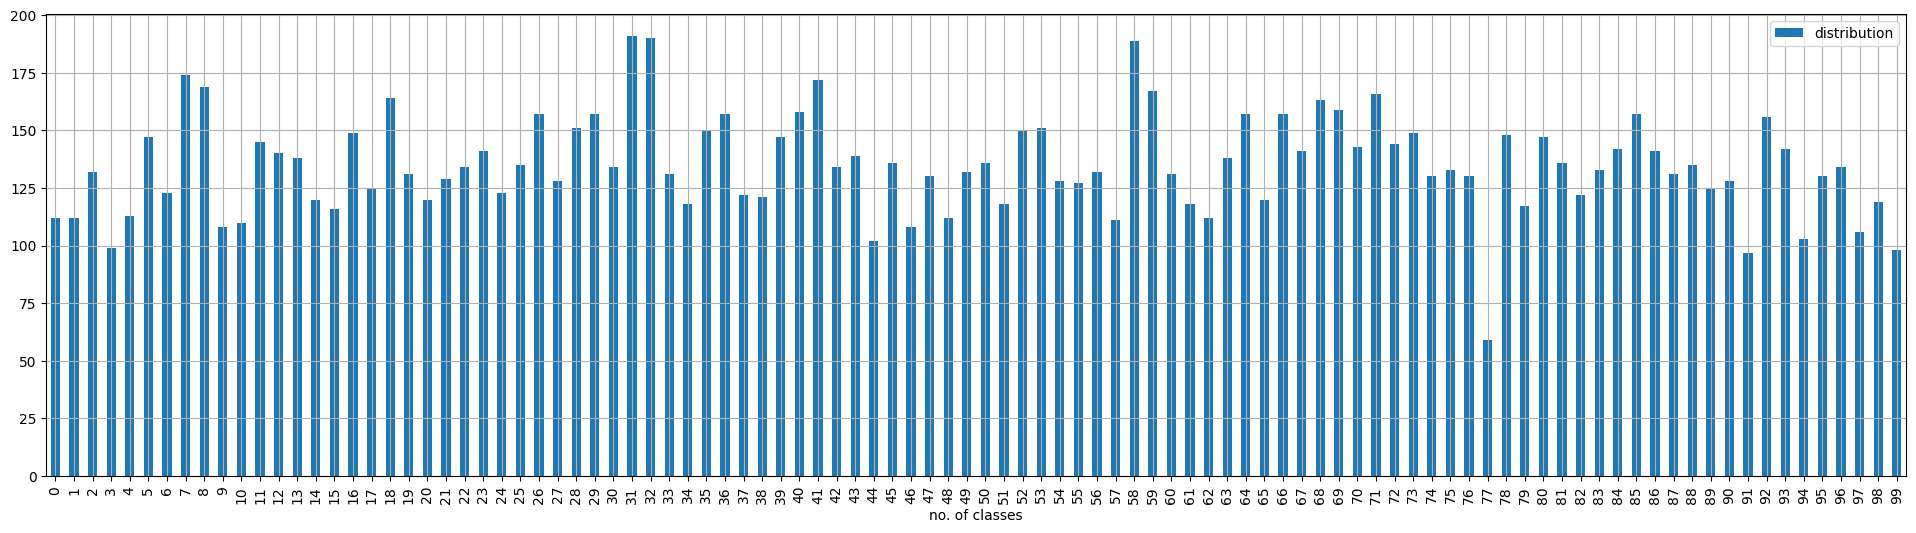

In [9]:
distribution_fn(dm.train_dataloader())

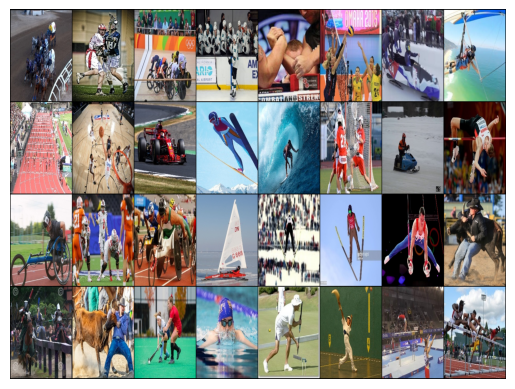

In [10]:
show_batch_images(images)

In [11]:
# _ = LitSportModel(global_pool='avg',in_chans=3,num_classes=100, global_block_counts=(0,1,1,1),depths=(1,1,3,1),dims=(24,48,22,96),heads=(2,2,2,2),kernel_sizes=(1,3,5,7),d2_scales=(2,2,3,4),use_pos_emb=(False,True,False,False),ls_init_value=1e-6,head_init_scale=1,expand_ratio=4,downsample_block=False,conv_bias=True,stem_type='overlap',head_norm_first=False,act_layer='relu',drop_path_rate=0.01,drop_rate=0)
# _ = LitSportModel.load_from_checkpoint( os.path.join( r"./checkpoints/ckpts/sports.ckpt" ) )
# model = torch.jit.load( os.path.join(r'./checkpoints/pths/sports_cpu.pt'),map_location='cpu')

In [12]:

model_cpu = torch.jit.load( os.path.join(r'./checkpoints/pths/sports_cpu.pt'), map_location=torch.device('cpu'))

with torch.no_grad():
    print(model_cpu(images).shape)
    print(model_cpu(images).device)


model = torch.jit.load( os.path.join(r'./checkpoints/pths/sports.pt'),  map_location=torch.device('cuda'))
with torch.no_grad():
    images = images.cuda()
    print(model(images).shape)
    print(model(images).device)

torch.Size([32, 100])
cpu
torch.Size([32, 100])
cuda:0


In [13]:
from torchinfo import summary

In [19]:
summary(model=model,input_size=(1,3,224,224),depth=10,col_names=['input_size','output_size','num_params','params_percent','trainable'])

Layer (type:depth-idx)                                            Input Shape               Output Shape              Param #                   Param %                   Trainable
LitSportModel                                                     --                        --                        --                             --                   True
├─EdgeNeXt: 1-1                                                   --                        --                        --                             --                   True
│    └─Sequential: 2-1                                            --                        --                        --                             --                   True
│    │    └─Conv2d: 3-1                                           --                        --                        1,176                       0.10%                   True
│    │    └─LayerNorm2d: 3-2                                      --                        --                        48

In [15]:
# plot_confusion_matrix(model,dm,classes=dm.train_ds.classes,path=os.path.join('..','assets'))